## 作成した特徴量を使ってモデルを学習するぞい

In [1]:
from __future__ import annotations
import itertools
import dataclasses
from typing import List, Union

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

In [2]:
TRAIN = pd.read_csv("data/preprocessed_train.csv", index_col=None, header=0).set_index("PassengerId")
TEST = pd.read_csv("data/preprocessed_test.csv", index_col=None, header=0).set_index("PassengerId")
display(TRAIN)
display(TEST)

,IntSex,Pclass,Under10YearsOld,IsPair,Parch,EmbarkedAtCherboug,Survived
PassengerId,,,,,,,
1,0,3,0,1,0,0,0
2,1,1,0,1,0,1,1
3,1,3,0,0,0,0,1
4,1,1,0,1,0,0,1
5,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...
887,0,2,0,0,0,0,0
888,1,1,0,0,0,0,1
889,1,3,0,1,2,0,0


,IntSex,Pclass,Under10YearsOld,IsPair,Parch,EmbarkedAtCherboug
PassengerId,,,,,,
892,0,3,0,0,0,0
893,1,3,0,1,0,0
894,0,2,0,0,0,0
895,0,3,0,0,0,0
896,1,3,0,1,1,0
...,...,...,...,...,...,...
1305,0,3,0,0,0,0
1306,1,1,0,0,0,1
1307,0,3,0,0,0,0


In [3]:
@dataclasses.dataclass(frozen=True)
class Result:
    model: sklearn.base.ClassifierMixin
    train: pd.DataFrame
    test: pd.DataFrame
    submit: pd.DataFrame


@dataclasses.dataclass(frozen=True)
class Score:
    name: str
    train_scores: List[float]
    test_scores: List[float]

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            {
                f"train_{self.name}": self.train_scores,
                f"test_{self.name}": self.test_scores,
            }
        )

    def __post_init__(self):
        if len(self.train_scores) != len(self.test_scores):
            raise ValueError("length is not same")

    @property
    def length(self):
        return len(self.train_scores)


@dataclasses.dataclass(frozen=True)
class CVResult:
    fit_time: List[float]
    score_time: List[float]
    scores: List[Score]

    def to_dataframe(self) -> pd.DataFrame:
        result = pd.DataFrame(
            {
                "fit_time": self.fit_time,
                "score_time": self.score_time,
            }
        )
        for score in self.scores:
            result = pd.concat([result, score.to_dataframe()], axis=1)

        return result


@dataclasses.dataclass(frozen=True)
class CVResults:
    params: List[Union[str, int]]
    results: List[CVResult]

    def __post_init__(self):
        if len(self.params) != len(self.results):
            raise ValueError("params and length is not same!")

    @classmethod
    def from_dict(cls, dict_results: dict) -> CVResults:
        return CVResults(params=dict_results.keys(), results=dict_results.values())

    def to_describe_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            {
                k: v.to_dataframe().describe().loc["mean", :]
                for k, v in zip(self.params, self.results)
            }
        ).transpose()

    def plot_and_display_table(self, plot_target="accuracy"):
        df = self.to_describe_dataframe()
        df[[f"train_{plot_target}", f"test_{plot_target}"]].plot(grid=True)
        display(df)


@dataclasses.dataclass
class RandomForestParams:
    n_estimators: int
    max_depth: int
    max_features: int
    min_samples_split: int
    min_samples_leaf: int

    def to_string(self) -> str:
        return ", ".join([f"{k}={v}" for k, v in dataclasses.asdict(self).items()])


## とりあえず学習
- train: 0.84
- test: 0.76(submitした)

In [4]:
def train_random_forest_classifier(train: pd.DataFrame, test: pd.DataFrame, randomforest_kwarg: dict ={}) -> Result:
    randomforest = RandomForestClassifier(**randomforest_kwarg)
    randomforest.fit(TRAIN.drop("Survived", axis=1), TRAIN.Survived)

    display( randomforest.feature_importances_)
    display(randomforest.score(TRAIN.drop("Survived", axis=1), TRAIN.Survived))

    submit = pd.DataFrame({
        "PassengerId": TEST.index,
        "Survived": randomforest.predict(TEST)
    })
    display(submit)

    return Result(
        model=randomforest,
        train=train,
        test=test,
        submit=submit
    )

train_random_forest_classifier(TRAIN, TEST)

array([0.51809016, 0.22234877, 0.06919418, 0.0495304 , 0.09033591,
       0.05050058])

0.8406285072951739

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Result(model=RandomForestClassifier(), train=             IntSex  Pclass  Under10YearsOld  IsPair  Parch  \
PassengerId                                                   
1                 0       3                0       1      0   
2                 1       1                0       1      0   
3                 1       3                0       0      0   
4                 1       1                0       1      0   
5                 0       3                0       0      0   
...             ...     ...              ...     ...    ...   
887               0       2                0       0      0   
888               1       1                0       0      0   
889               1       3                0       1      2   
890               0       1                0       0      0   
891               0       3                0       0      0   

             EmbarkedAtCherboug  Survived  
PassengerId                                
1                             0         0  
2  

## k-cross-validationしよう
過学習のアレみるなら、交差検証したほうが良さげ

baseline: `test_score = 0.815980`

In [5]:
def random_forest_classifier_cross_validation(
    train: pd.DataFrame,
    model: sklearn.base.ClassifierMixin,
    cv: int = 10,
) -> CVResult:
    cv_results = cross_validate(
        model,
        train.drop("Survived", axis=1),
        train.Survived,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        scoring=["accuracy", "roc_auc"],
    )

    return CVResult(
        fit_time=cv_results["fit_time"],
        score_time=cv_results["score_time"],
        scores=[
            Score(
                name=name,
                train_scores=cv_results[f"train_{name}"],
                test_scores=cv_results[f"test_{name}"],
            )
            for name in ["accuracy", "roc_auc"]
        ],
    )


(
    random_forest_classifier_cross_validation(TRAIN, RandomForestClassifier())
    .to_dataframe()
    .mean()
)


fit_time          0.390714
score_time        0.070408
train_accuracy    0.841003
test_accuracy     0.819338
train_roc_auc     0.893217
test_roc_auc      0.849200
dtype: float64

### 特徴量を一つ削ってみる

In [6]:
RESULTS_1_LESS_FEATURES = CVResults.from_dict({
    str(params): random_forest_classifier_cross_validation(
        TRAIN[list(params) + ["Survived"]], RandomForestClassifier(random_state=0)
    )
    for params in itertools.combinations(TEST.columns, len(TEST.columns) - 1)
})


In [7]:
display(
    RESULTS_1_LESS_FEATURES.to_describe_dataframe().sort_values(
        "test_accuracy", ascending=False
    )
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
"('IntSex', 'Pclass', 'Under10YearsOld', 'Parch', 'EmbarkedAtCherboug')",0.298271,0.057862,0.827410,0.815968,0.882496,0.857845
"('IntSex', 'Pclass', 'Under10YearsOld', 'IsPair', 'Parch')",0.314401,0.056302,0.829156,0.804782,0.880443,0.853640
"('IntSex', 'Pclass', 'Under10YearsOld', 'IsPair', 'EmbarkedAtCherboug')",0.310094,0.058059,0.822173,0.798015,0.879118,0.866330
"('IntSex', 'Under10YearsOld', 'IsPair', 'Parch', 'EmbarkedAtCherboug')",0.305762,0.061740,0.811323,0.794619,0.842713,0.816137
"('IntSex', 'Pclass', 'IsPair', 'Parch', 'EmbarkedAtCherboug')",0.397954,0.076494,0.822921,0.792409,0.875955,0.826668
"('Pclass', 'Under10YearsOld', 'IsPair', 'Parch', 'EmbarkedAtCherboug')",0.331112,0.069694,0.734382,0.703795,0.761023,0.721304


一つ消してダメなら消す必要なさそう

**特徴量はそのまま使うことにする**

というか、決定木ベースのアルゴリズムだと特徴量の削減はあまり意味ないか。。
学習過程で与えられた特量量のいち部を使って分類やってみて、最もいいやつを云々とかやっているし。

### randomforestのパラメータをチューニングしてみよう
https://engineering.linecorp.com/ja/blog/abuser-analysis-hyperparameter-tuning-using-random-forests/
↑をなぞってみる

順々に最適な値として持ってしまっているが、本当は組み合わせで最適化する必要あり

#### max_depth

In [8]:
RESULTS_MAX_DEPTH = CVResults.from_dict({
    max_depth: random_forest_classifier_cross_validation(
        TRAIN, RandomForestClassifier(max_depth=max_depth, random_state=0)
    )
    for max_depth in range(1, 30)
})

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,0.380798,0.056308,0.785759,0.786804,0.840014,0.837403
2,0.312379,0.065045,0.799352,0.794644,0.848700,0.838494
3,0.330235,0.085370,0.808955,0.804744,0.860029,0.850052
4,0.382901,0.069341,0.820303,0.796929,0.867909,0.856575
5,0.312428,0.062061,0.832898,0.817091,0.877002,0.852764
6,0.544465,0.143176,0.840006,0.819338,0.885914,0.853421
7,0.858861,0.136318,0.841003,0.819338,0.891676,0.852771
8,0.706813,0.105941,0.841003,0.822709,0.893025,0.848174
9,0.393297,0.084470,0.841003,0.820462,0.893346,0.848678
10,0.381786,0.078846,0.841003,0.820462,0.893383,0.847878


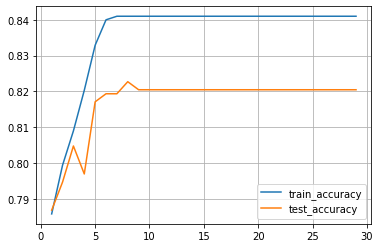

In [9]:
RESULTS_MAX_DEPTH.to_describe_dataframe()[["train_accuracy", "test_accuracy"]].plot(grid=True)
display(RESULTS_MAX_DEPTH.to_describe_dataframe())

In [10]:
MAX_DEPTH_RANGE=range(4, 11)

#### n_estimator
ブレブレだけど、10ぐらいで良さそう

In [11]:
RESULTS_N_ESTIMATOR = CVResults.from_dict({
    n_estimator: random_forest_classifier_cross_validation(
        TRAIN, RandomForestClassifier(n_estimators=n_estimator, random_state=0)
    )
    for n_estimator in range(1, 100)
})

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,0.009667,0.011873,0.828657,0.802484,0.874991,0.819657
2,0.012277,0.011742,0.833645,0.804732,0.885881,0.839644
3,0.014435,0.011014,0.835267,0.802497,0.889784,0.842863
4,0.022963,0.015705,0.837761,0.805855,0.890980,0.844811
5,0.019360,0.011859,0.838758,0.811461,0.891216,0.844100
...,...,...,...,...,...,...
95,1.876150,0.375312,0.841003,0.819338,0.893415,0.847743
96,0.913919,0.206709,0.841003,0.819338,0.893454,0.847850
97,1.083569,0.158013,0.841003,0.819338,0.893428,0.847930
98,0.794521,0.255619,0.841003,0.819338,0.893405,0.847983


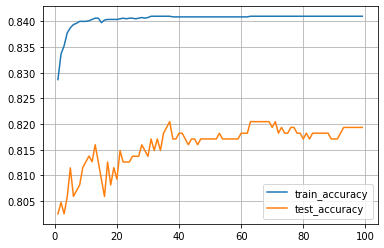

In [12]:
RESULTS_N_ESTIMATOR.plot_and_display_table()

In [13]:
N_ESTIMATOR_RANGE = range(30, 101)

#### max_feature
（なんか特徴量をそもそも削るのは上でやったので、削らないのが良さそうな気がする）

特徴量がそもそも少ないので、下手に弄らずにデフォルト（`auto`）で良さそう

最適化対象から外す


In [14]:
RESULTS_MAX_FEATURES = CVResults.from_dict(
    {
        max_features: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                max_features=max_features,
                random_state=0
            ),
        )
        for max_features in range(1, len(TEST.columns) + 1)
    }
)


dataset features Index(['IntSex', 'Pclass', 'Under10YearsOld', 'IsPair', 'Parch',
       'EmbarkedAtCherboug'],
      dtype='object')


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,1.332320,0.122203,0.841003,0.819338,0.892987,0.847504
2,0.710076,0.132804,0.841003,0.820462,0.893371,0.847931
3,0.808096,0.195967,0.841003,0.819338,0.893513,0.848200
4,0.764594,0.140514,0.841003,0.820462,0.893582,0.847800
5,0.746500,0.194455,0.841003,0.823833,0.893480,0.848307
6,0.565853,0.120078,0.841003,0.822709,0.893385,0.847135


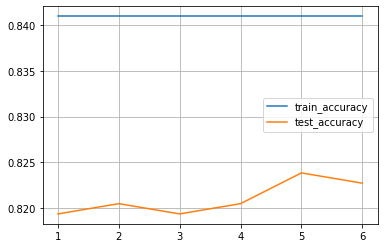

In [15]:
print("dataset features", TEST.columns)
RESULTS_MAX_FEATURES.plot_and_display_table()

#### min_samples_split

In [16]:
RESULTS_MIN_SAMPLES_SPLIT = CVResults.from_dict(
    {
        min_samples_split: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                min_samples_split=min_samples_split,
                random_state=0
            ),
        )
        for min_samples_split in range(2, 21)
    }
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
2,0.825759,0.163591,0.841003,0.820462,0.893371,0.847931
3,0.762174,0.107704,0.840878,0.822709,0.892260,0.848866
4,0.994025,0.304044,0.839382,0.820462,0.891146,0.849724
5,0.784207,0.155427,0.838135,0.818215,0.889680,0.854109
6,0.984668,0.306573,0.837886,0.818215,0.888086,0.854638
7,0.739432,0.119654,0.837511,0.817091,0.887274,0.853789
8,0.677263,0.118644,0.835641,0.815968,0.885973,0.851565
9,0.588594,0.182076,0.835516,0.817091,0.884647,0.853078
10,0.672217,0.104783,0.835392,0.815968,0.883719,0.857380
11,0.422063,0.071793,0.834893,0.819338,0.883249,0.859264


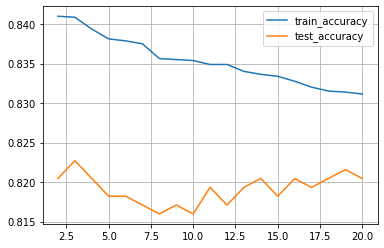

In [17]:
RESULTS_MIN_SAMPLES_SPLIT.plot_and_display_table()

In [18]:
MIN_SAMPLES_SPLIT_RANGE = range(2, 21)

#### min_sample_leaf

In [19]:
RESULTS_MIN_SAMPLES_LEAF = CVResults.from_dict(
    {
        min_samples_leaf: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                min_samples_leaf=min_samples_leaf,
                random_state=0
            ),
        )
        for min_samples_leaf in range(2, 6)
    }
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
2,1.049335,0.223901,0.836888,0.818215,0.886761,0.853558
3,1.026798,0.173641,0.833646,0.818215,0.882164,0.859517
4,0.466195,0.172776,0.827909,0.815968,0.878948,0.859129
5,0.614681,0.096360,0.827036,0.814844,0.875014,0.854025


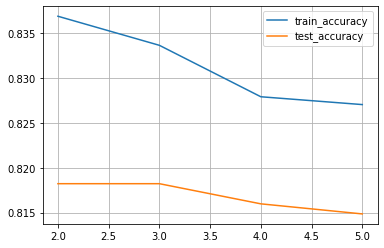

In [20]:
RESULTS_MIN_SAMPLES_LEAF.plot_and_display_table()

In [21]:
MIN_SAMPLES_LEAF_RANGE = range(2, 4)

#### grid searchするぞ
数時間コース

In [ ]:
cases = [
    RandomForestParams(*params)
    for params in itertools.product(
        N_ESTIMATOR_RANGE,
        MAX_DEPTH_RANGE,
        MAX_FEATURES_RANGE,
        MIN_SAMPLES_SPLIT_RANGE,
        MIN_SAMPLES_LEAF_RANGE,
    )
]
RESULTS_GRID_SEARCH = CVResults.from_dict(
    {
        param.to_string(): random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                n_estimators=param.n_estimators,
                max_depth=param.max_depth,
                max_features=param.max_features,
                min_samples_split=param.min_samples_split,
                min_samples_leaf=param.min_samples_leaf,
                random_state=0
            ),
        )
        for param in cases
    }
)
